# Generate visible slope distribution from shadow lookup table

Using a ray-casting shadow lookup table, return a table of probabilities that a given surface facet (az, slope) is in shadow. The probabilities are interpolated from the lookup table which includes ray-casting runs from a variety of synthetic Gaussian surfaces with varying RMS slopes and local solar incidence angles. 

The inputs to the function are:

- `rms_slope`: Root-mean-square slope of a Gaussian slope distribution of surface facets
- `sun_theta`: To-sun incidence angle w.r.t. the surface
- `sun_az`: To-sun azimuth angle w.r.t. the surface
- `sc_theta`: To-spacecraft exitance angle w.r.t. the surface
- `sc_az`: To-spacecraft azimuth angle w.r.t. the surface
- (optional) `shadow_lookup_path`: Path to custom 4D shadow lookup file

The default lookup table `shade_lookup_4D.npy` predicts shadowing across:

- RMS slopes from 0 to 50 degrees (in 5 degree increments)
- cos(solar incidence angle) from 0 to 1 (in 0.1 increments)

The table returns a 2D grid of probabilities of slope shadowing corresponding to the following range of facet slope azimuth and angle combinations:

- Slope azimuths measured from North from 0 to 360 degrees (in 10 degree increments)
- Slope angles measured from a level surface from 0 to 90 degrees (in 2 degree increments)

The table interpolates between the supplied RMS slope (`rms_slope`) and solar incidence angle (`sun_theta`) and returns the 2D grid of shadow probabilities as a function of azimuth and slope angle.

Since shadow lookup was generated with solar azimuth = 270 degrees, we rotate the table such that the shadowing of the returned facets are specified with respect to the supplied solar azimuth (`sun_az`).

Since the observed shadowing distribution will vary based on the observation direction, the shadow facet table is also projected onto the plane perpendicular to the vector of the viewing direction supplied (`sc_theta`, `sc_az`). For example, at 0 phase angle (spacecraft and sun vectors are the same), all shadows from the point of view of the spacecraft are hidden.

In [1]:
%reset -sf
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
from roughness import roughness as r
plt.style.use('dark_background')
imgdir = path.join(r.ROUGHNESS_DIR, 'docs', 'img') + path.sep

Text(0, 0.5, 'Facet azimuth angle [deg]')

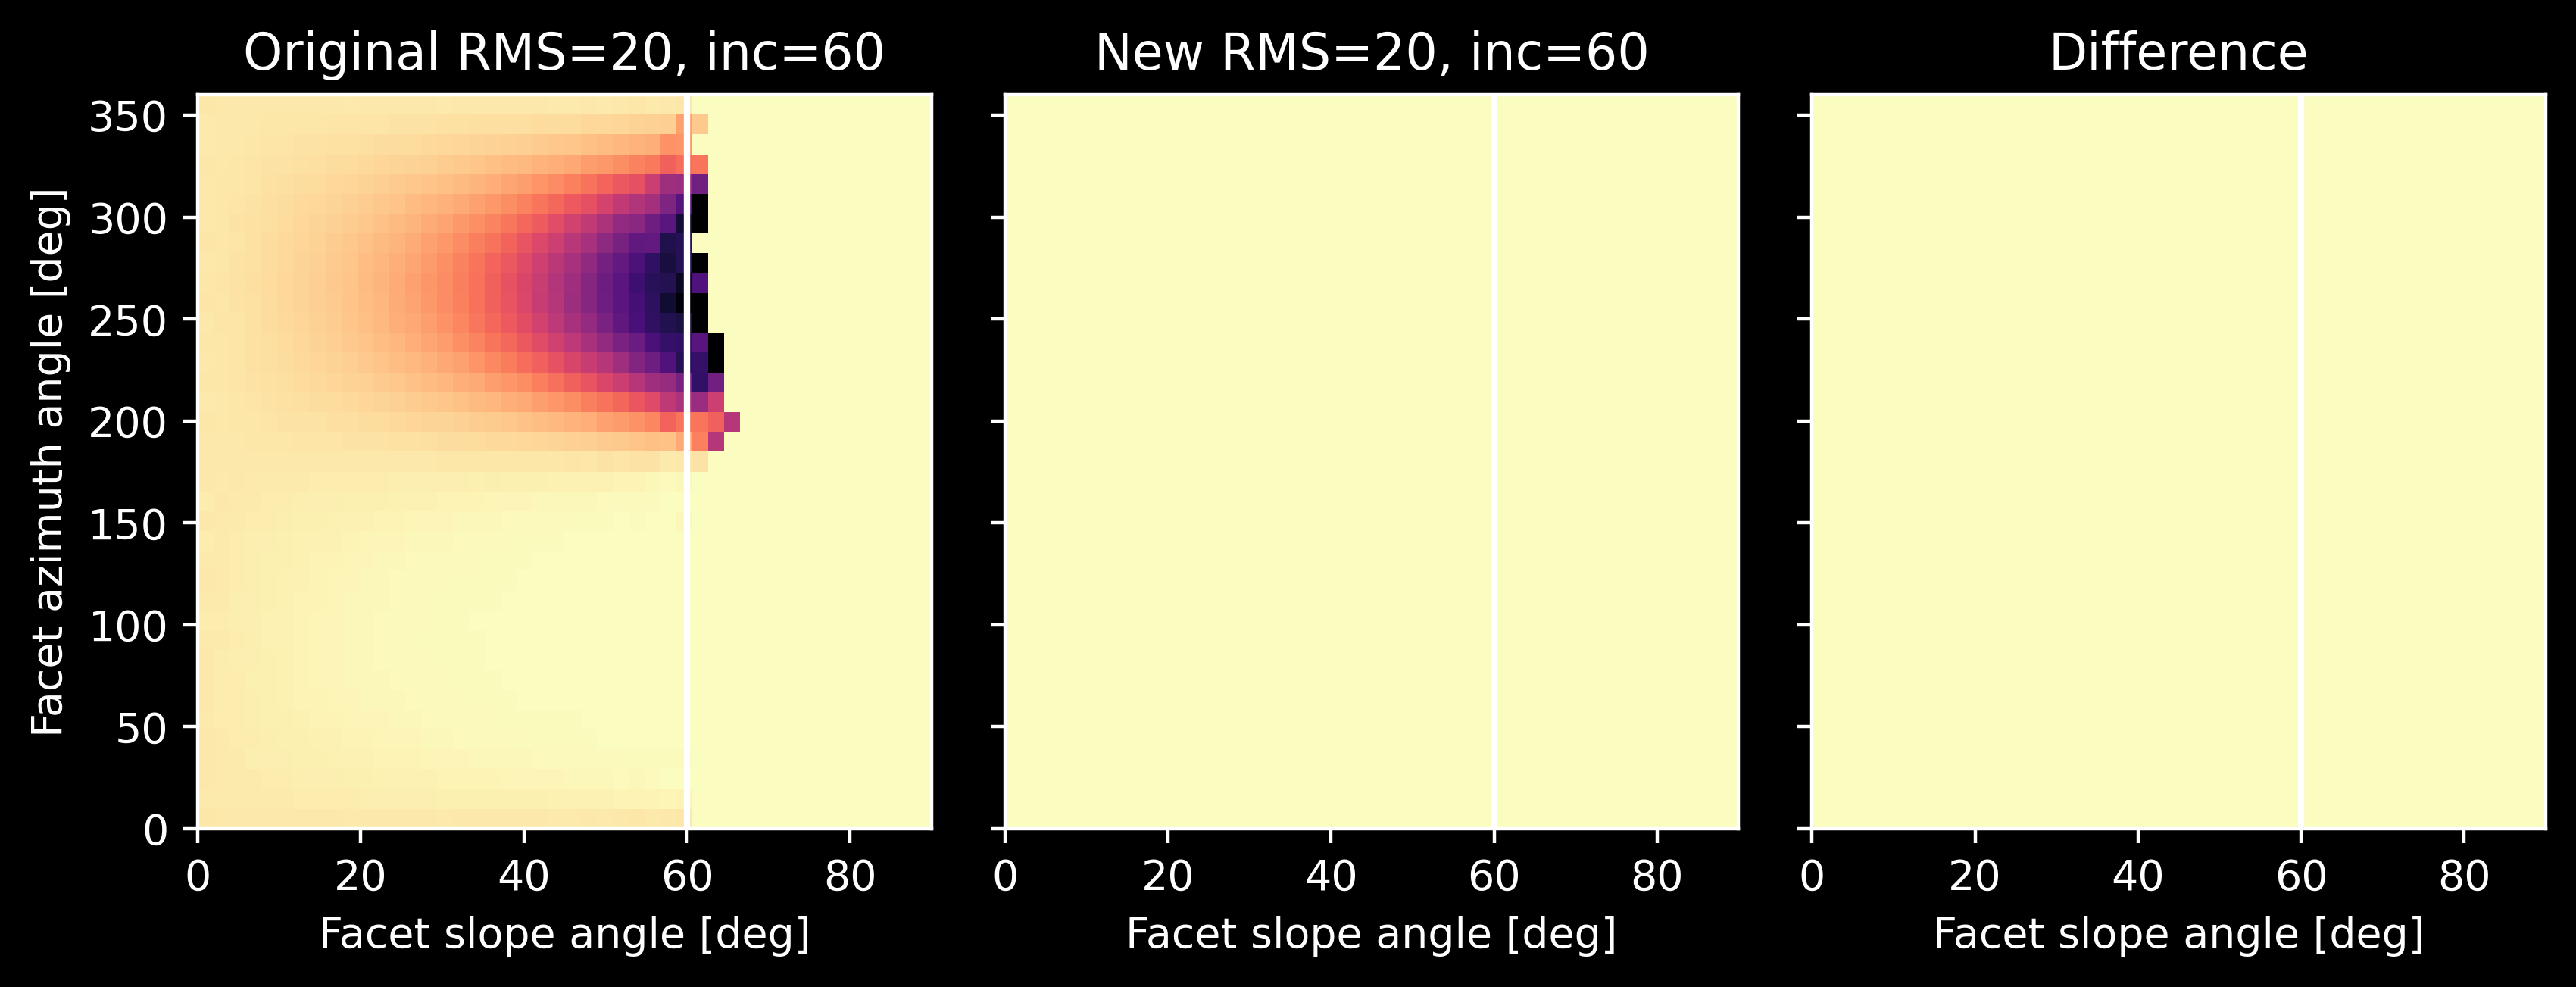

In [3]:
# Get raw shadow table with solar incidence angle below
orig_fp = r.ROUGHNESS_DIR+'/data/shade_lookup_4D_old.npy'
new_fp = r.ROUGHNESS_DIR+'/shadow_table/out/shade_lookup_4D.npy'
fps = [orig_fp,new_fp]

rms_slope = 20
sun_theta = 60
sun_az = 270

fig,axes = plt.subplots(1,3,figsize=(10,4),dpi=400,sharey=True)
axes_flat = axes.ravel()
plt.subplots_adjust(wspace=.1)

orig_sl = r.load_shadow_lookup(fps[0])
orig_shadow_frac = r.get_shadow_table(rms_slope, sun_theta, sun_az, orig_sl)
axes_flat[0].imshow(orig_shadow_frac, extent=(0, 90, 0, 360), aspect=90 /360, cmap='magma_r', vmin=0, vmax=1.0)

new_sl = r.load_shadow_lookup(fps[1])
new_shadow_frac = r.get_shadow_table(rms_slope, sun_theta, sun_az, new_sl)
axes_flat[1].imshow(new_shadow_frac, extent=(0, 90, 0, 360), aspect=90 /360, cmap='magma_r', vmin=0, vmax=1.0)

axes_flat[2].imshow((new_shadow_frac-orig_shadow_frac), extent=(0, 90, 0, 360), aspect=90 /360, cmap='magma_r', vmin=0, vmax=1.0)

titles=['Original RMS=20, inc=60','New RMS=20, inc=60','Difference']
for i in range(0,3):
    axes_flat[i].set_xlabel('Facet slope angle [deg]')
    axes_flat[i].vlines((60),0,360,color='w')
    axes_flat[i].set_title(titles[i],fontsize=12)
axes_flat[0].set_ylabel('Facet azimuth angle [deg]')
#axes_flat[0].colorbar(label='P(shadowed)')



In [6]:
np.max(new_shadow_frac)

-1.0

In [38]:
print(orig_shadow_frac.shape)
test=np.empty(orig_shadow_frac.shape)
print(test.shape)
print(test[0,0])

(37, 46)
(37, 46)
6.92400246898645e-310


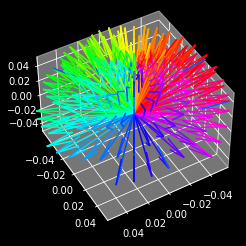

In [9]:
# Sanity check on facet vectors (slope in 0-90, az in 0-360)
theta_surf, azimuth_surf = r.get_facet_grids(shadow_frac)
cartesian_surf = r.sph2cart(np.radians(theta_surf), np.radians(azimuth_surf))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45, 60)

X, Y, Z = cartesian_surf.reshape((37*46, 3)).T + 1e-8
O = np.zeros(len(X))  # origin

# Color by az angle
c = np.arctan2(Y, X)
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# Colormap
c = plt.cm.hsv(c)
# Subsample because there are a lot of vectors
s = slice(None, None, 11)
q = ax.quiver(O[s], O[s], O[s], X[s], Y[s], Z[s], colors=c[s], length=0.08, normalize=True)


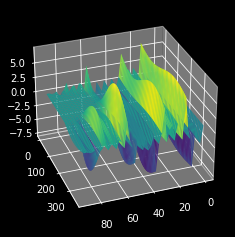

In [10]:
# Transcibed the "correction" steps from TI_Scripts. This
# part should do the view angle correction but... looks weird
sc_theta = 20
sc_az = 270
theta, az = (np.radians(30), np.radians(sc_az))

cartesian_sc = r.sph2cart(theta, az)
cos_surf_sc = np.dot(cartesian_surf, cartesian_sc)

angle = np.arccos(cos_surf_sc)
angle[angle > np.pi/2] = np.pi/2
corr = (1/np.cos(theta_surf))*np.cos(angle)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(30, 70)

ax.plot_surface(theta_surf, azimuth_surf, corr, cmap='viridis')

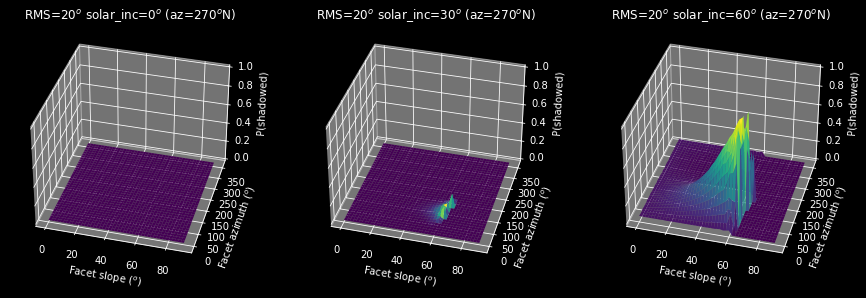

In [11]:
# Get shadow table from lookup
rms_slope = 20
solar_az = 270

fig = plt.figure(figsize=(15, 8))
sun_thetas = (0, 30, 60)
for i, solar_inc in enumerate(sun_thetas):
    shadow_table = r.get_shadow_table(rms_slope, solar_inc, solar_az, sl)
    ax = fig.add_subplot(1, len(sun_thetas), i+1, projection='3d')
    ax.view_init(35, -75)
    ax.plot_surface(theta_surf, azimuth_surf, shadow_table, cmap='viridis')
    ax.set_title(f'RMS={rms_slope}$^o$ solar_inc={solar_inc}$^o$ (az={solar_az}$^o$N)')
    ax.set_xlabel('Facet slope ($^o$)')
    ax.set_ylabel('Facet azimuth ($^o$)')
    ax.set_zlabel('P(shadowed)')
    ax.set_zlim(0, 1)

# plt.savefig('./shadow_tables.png', dpi=300)

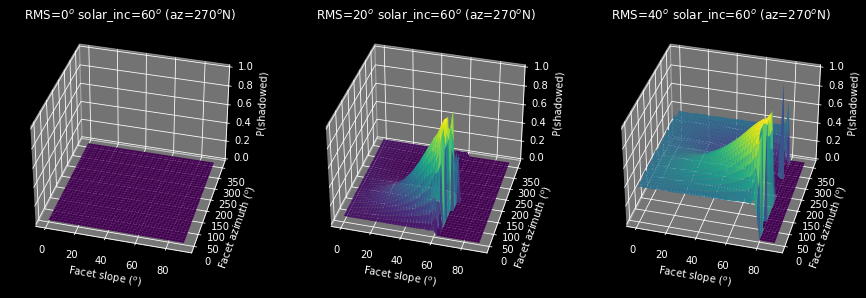

In [12]:
# Compare rms slopes
solar_inc = 60
solar_az = 270

fig = plt.figure(figsize=(15, 8))
rms_slopes = (0, 20, 40)
for i, rms_slope in enumerate(rms_slopes):
    shadow_table = r.get_shadow_table(rms_slope, solar_inc, solar_az, sl)
    ax = fig.add_subplot(1, len(sun_thetas), i+1, projection='3d')
    ax.view_init(35, -75)
    ax.plot_surface(theta_surf, azimuth_surf, shadow_table, cmap='viridis')
    ax.set_title(f'RMS={rms_slope}$^o$ solar_inc={solar_inc}$^o$ (az={solar_az}$^o$N)')
    ax.set_xlabel('Facet slope ($^o$)')
    ax.set_ylabel('Facet azimuth ($^o$)')
    ax.set_zlabel('P(shadowed)')
    ax.set_zlim(0, 1)

# plt.savefig('./shadow_tables.png', dpi=300)

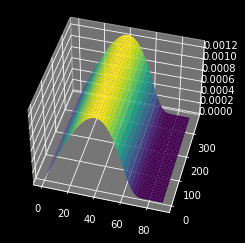

In [13]:
# Get probability of certain facets, given rms slope dist
slope_correction = r.slope_dist(np.radians(theta_surf), np.radians(rms_slope))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45, -75)
ax.plot_surface(theta_surf, azimuth_surf, slope_correction, cmap='viridis')

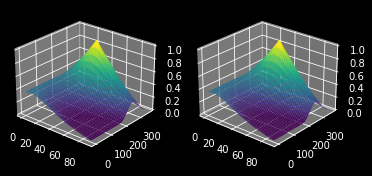

In [14]:
# Project facet vectors onto plane perp to spacecraft vec
cartesian_sc = r.sph2cart(*np.radians((40, 280)))

# Steps (see view_correction)
proj = r.proj_orthogonal(cartesian_surf, cartesian_sc)
visible = 1-np.linalg.norm(proj, axis=2)
cos_angle = np.dot(cartesian_surf, cartesian_sc)
visible[cos_angle < 0] = 0

# Comparison
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(25, -50)
ax.plot_surface(theta_surf, azimuth_surf, visible, cmap='viridis')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(25, -50)
vis_corr = r.view_correction(cartesian_surf, cartesian_sc)
ax.plot_surface(theta_surf, azimuth_surf, vis_corr, cmap='viridis')


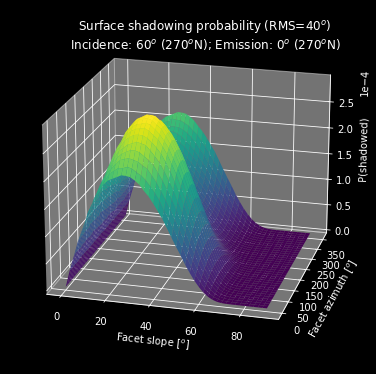

In [15]:
# Full corrected shadow table
sc_theta = 0
shadow_prob = r.get_shadow_prob(rms_slope, sun_theta, sun_az, sc_theta, sc_az, sl)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.view_init(20, -75)
ax.plot_surface(theta_surf, azimuth_surf, shadow_prob, cmap='viridis')
title = f'Surface shadowing probability (RMS={rms_slope}$^o$)\n'
title += f'Incidence: {sun_theta}$^o$ ({sun_az}$^o$N); '
title += f'Emission: {sc_theta}$^o$ ({sc_az}$^o$N)'
plt.suptitle(title, y=0.97)
ax.set_xlabel('Facet slope [$^o$]')
ax.set_ylabel('Facet azimuth [$^o$]')
ax.set_zlabel('P(shadowed)')
plt.ticklabel_format(axis="z", style="sci", scilimits=(0,0))
fig.subplots_adjust(left=-0.05, right=0.95, bottom=0, top=1)
plt.savefig(imgdir + 'shadow_fraction.png', dpi=300)